# Network classification with PyTorch
Classification is a problem of predicting wether something is one thing or another (there are more than just one options at times)

In [1]:
## 1. Make classification data
import sklearn
from sklearn.datasets import make_circles
import numpy as np

#Make 1000 samples
n_samples = 1000

# Creating circles

X, y = make_circles(n_samples,
                    noise=.03,
                    random_state=42)
len(X), len(y)

(1000, 1000)

In [2]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"\nFirst 5 samples of y:{y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y:[1 1 1 1 0]


In [3]:
# Make a dataframe of circle
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(15)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


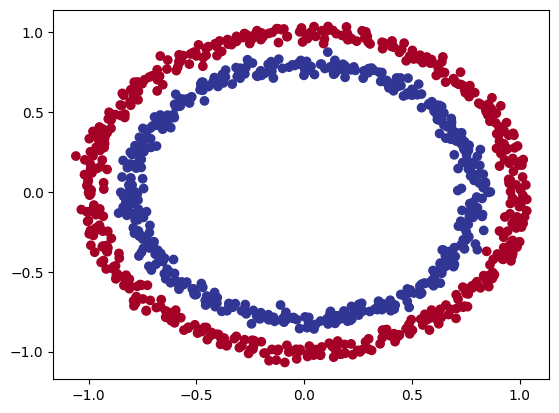

In [4]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data that is worked here is a toy data set. A dataset that is small enough to expirment on but sizeable to practice fundamentals

## Check input and output shapes. Exploring that the tensors and arrays are converting correctly.

In [5]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")
# This means that two features of x will try to predict one value of y
# y is a scalar

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape for one sample of X: (2,) and the same for y: ()


In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [8]:
import torch
# Done this way to ensure that it becomes float 32, rather than float64.
# tensor = torch.tensor(numpy_array) turned it into a tensor but made it of float64
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

In [9]:
y_tensor[:5], X_tensor[:5]

(tensor([1., 1., 1., 1., 0.]),
 tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]))

In [10]:
X_tensor.size(), X_tensor.ndim

(torch.Size([1000, 2]), 2)

In [11]:
y_tensor.size(), y_tensor.ndim

(torch.Size([1000]), 1)

# Splitting the training and test data, going to do a 80% 20% split

In [12]:
train_split = int(.8 * len(X_tensor))
X_train, y_train = X_tensor[:train_split], y_tensor[:train_split]
X_test, y_test = X_tensor[train_split:], y_tensor[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

# Could also do sklearn to split data. Below will be the code
```
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, = train_test_split(x,
                                                     y,
                                                     test_size=0.2
                                                     random_state=42
                                                    )
```

## Building our model

The model will classifiy our blue and red dots.

To do so, we want to:
1. Setup device agnoistic code so our code will run on an accelerator (GPU) if there is one use it.
2. Construct a model (```by subclassing nn.Module```)
3. Define a loss function and optimizer
4. Create a trainning and test loop.

In [13]:
# Agnositc code:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Device agnostic code has been created

Now:
1. Subclass `nn.module` (almost all modules in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` Layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation needed by nn.Module)
4. Instatiate an instance of our model class and send it to the target device

### The more hidden features the more opportunity our model has to a chance to learn our data

In [14]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self): # __init__ needs to pass in self.
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscales and outputs 5
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer (needs to line up), and outputs a single feature. Same shape as y.

  # 3. Define a forward() method that outlines a forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x is the input data: x -> layer_1 -> layer_2 -> output. First x goes into layer_1 then outputs 5 features into layer_2
# 4. Instantiate an instance of our model class and send it to the target device

In [15]:
model_0 = CircleModelV0().to(device) # Has the instantion to be run on the cpu or gpu. Which ever is avaliable. It will prefer the GPU if avaliable.

In [16]:
next(model_0.parameters()).device # This code will check if our instanation is on the GPU or CPU

device(type='cpu')

# Replicating the model above by using nn.Sequential()
- Instead of subclassing nn.Module we use nn.Sequential, it implements most of the code for us from subclassing CircleModel class subset of nn.Module
- The benefits of subclassing, with more complex forwards and networks it is good to know how to do subclassing of nn.Module
- For this case we will use the nn.Sequential
- Unlike before when we created weight and bias ourself. PyTorch is doing this for us

In [17]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4610,  0.5236],
                      [ 0.3862, -0.2995],
                      [-0.5494,  0.2177],
                      [-0.2832, -0.0528],
                      [-0.3964,  0.4202]])),
             ('0.bias',
              tensor([ 2.7914e-01,  3.8181e-02, -3.7417e-01, -1.5030e-04, -1.7418e-02])),
             ('1.weight',
              tensor([[ 0.0857,  0.3883, -0.0273,  0.1526, -0.2757]])),
             ('1.bias', tensor([0.3856]))])

In [19]:
# Make predictions
# At this point the model is not trained, it will try to predict with the random values pytorch provided
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 prediction:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 prediction:
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]])

First 10 labels:
tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0.])


 # Loss function & Optimizer and a Training loop

 Which loss function or optimizer would be used in this case:

 It is problem specific.

 For example for regression you might want MAE or MSE (Mean absolute error or mean squared error)

 For classification we will use binary cross entropy or categorical cross entropy (cross entropy).

 For optimizers, two of the most common and useful are SGD and adam.

* For the loss function, i will use `torch.nn.BCEWithLogitsLoss()` ; Binary cross entropy
* For different optimizers see `torch.optim`

In [20]:
# Loss function & Optimizer and a Training loop
# Binary cross entropy loss
loss_fn = nn.BCEWithLogitsLoss() # Sigmod activation function built it

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
# Calculate accuracy : True_positive / (True_positive+True_negative) * 100
# Out of 100 examples what percentage does the model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

# 3. Training our model
# Going from raw logits --> Prediction Probabilites --> Prediction Labels
Need to build a training loop:
1. Forward pass
2. Calculate the loss
3. Zero gradients
4. Perform backpropagation on the loss
5. Step the optimizer (gradient descent)

**Logits** - The models raw outputs

The **logits** can be converted into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert the model's predictions probabilities to predictions labels by either rounding or taking the `argmax()`.

In [22]:
# Viewing the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4560],
        [0.6365],
        [0.3818],
        [0.4013],
        [0.3648]])

In [23]:
y_test[:5]

tensor([1., 1., 1., 1., 0.])

In [24]:
# Using the sigmoid activation function on our model logits to turn them into prediction probilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6121],
        [0.6540],
        [0.5943],
        [0.5990],
        [0.5902]])

In [25]:
# Cannot use the round on the RAW logits. Must use the sigmoid activation function to convert the raw output
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

From our predictions probability values, we need to perform a range-style rounding on them:
* Split at 0.5

In [26]:
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  # Training
  model_0.train()

  # 1. Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits --> pred probs --> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsloss expects raw logits as inputs
                 y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ## Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calucalte the test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    #Print whats going on as we go
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71868 | Acc: 50.12% | Test Loss: 0.72786 | Test acc: 49.50%


## Making Predictions and evaluate model

From the metrics its looks like our model isnt learning anything
Now it will be inspected.

To do so going to import a function called `plot_decision_boundary()`.

In [27]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

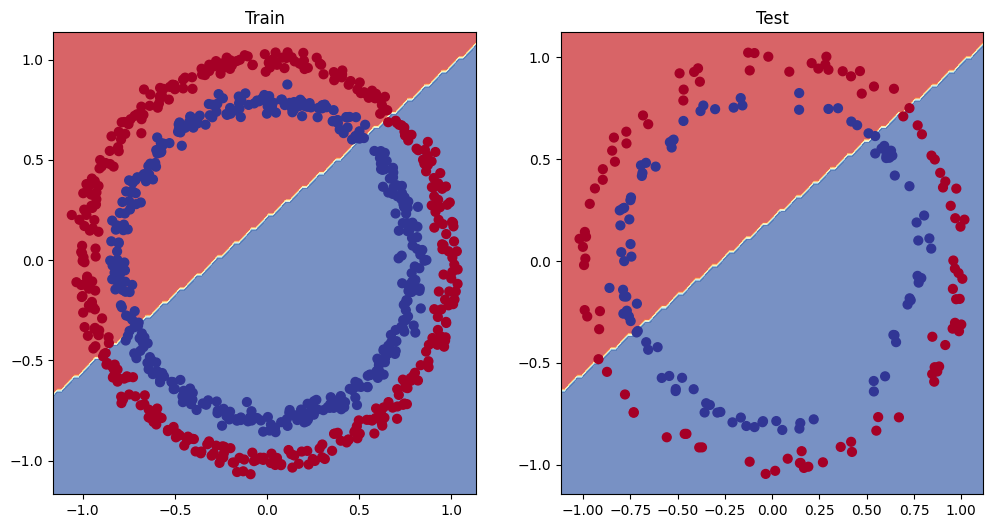

In [28]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test )

# The issue here is, Since that the data is circular, and we are using linear layers. This is causing issues.

Improving our model (from a perspective). How should I improve my model??
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units. (`Outfeatures, Infeatures`). Go from 5 hidden units to 10 hidden units.
* Fit/Train for longer
* Chaning the activation functions
* Change the learning rate of the model
* Change the loss function

These options are from a model perspective beacuase its ways to improve the model. We can also improve a model from a data perspective

Because these options are all values we (as machine learning and data scientist)can be referred to as hyperparameters.

In [29]:
X_train[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [30]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
  # When subclassing nn.Module you have to override the forward function.
  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device) # Instance of CircleModelV1
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [32]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  # Training
  model_1.train()

  # 1. Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits --> pred probs --> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsloss expects raw logits as inputs
                 y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval() # Put it in evaluation mode
  with torch.inference_mode():
     # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
  # 2 Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 25 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}| Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70026 | Acc: 46.25% | Test Loss: 0.68626| Test Acc: 55.00%
Epoch: 25 | Loss: 0.69518 | Acc: 47.62% | Test Loss: 0.68848| Test Acc: 57.00%
Epoch: 50 | Loss: 0.69379 | Acc: 48.50% | Test Loss: 0.69117| Test Acc: 57.00%
Epoch: 75 | Loss: 0.69314 | Acc: 51.38% | Test Loss: 0.69329| Test Acc: 55.00%
Epoch: 100 | Loss: 0.69281 | Acc: 53.12% | Test Loss: 0.69493| Test Acc: 42.50%
Epoch: 125 | Loss: 0.69265 | Acc: 52.62% | Test Loss: 0.69615| Test Acc: 43.00%
Epoch: 150 | Loss: 0.69256 | Acc: 52.62% | Test Loss: 0.69706| Test Acc: 43.00%
Epoch: 175 | Loss: 0.69252 | Acc: 52.25% | Test Loss: 0.69772| Test Acc: 43.00%
Epoch: 200 | Loss: 0.69250 | Acc: 52.50% | Test Loss: 0.69819| Test Acc: 43.00%
Epoch: 225 | Loss: 0.69249 | Acc: 52.75% | Test Loss: 0.69854| Test Acc: 43.00%
Epoch: 250 | Loss: 0.69248 | Acc: 52.50% | Test Loss: 0.69878| Test Acc: 43.50%
Epoch: 275 | Loss: 0.69248 | Acc: 52.62% | Test Loss: 0.69896| Test Acc: 43.50%
Epoch: 300 | Loss: 0.69248 | Acc: 52.50% | Te

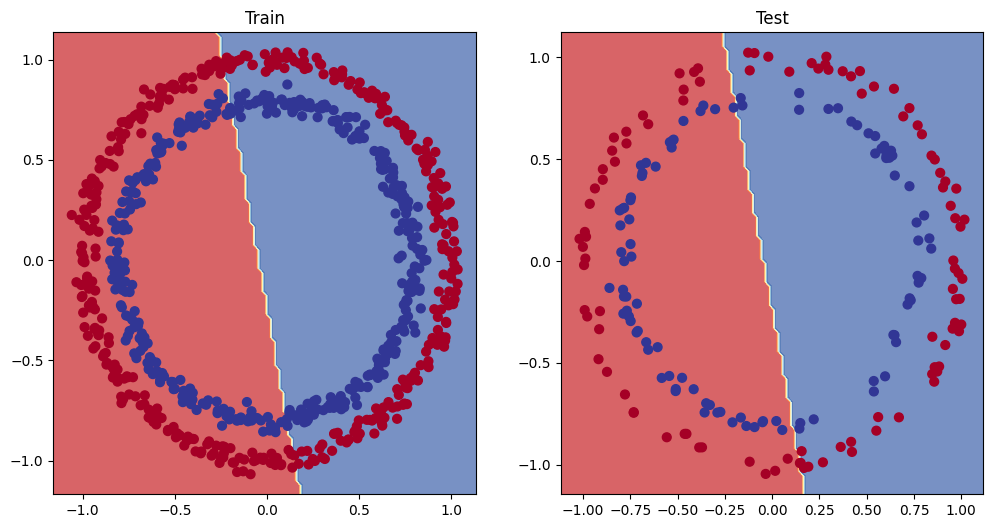

In [33]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test )

## Nonlinear activations | Nonlinearity
Our model didnt work before because we only gave our model linear lines to learn on, however our data is not linear. For this we will need to use a non-linear layer

## Recreating non-linear data (red and blue circles)

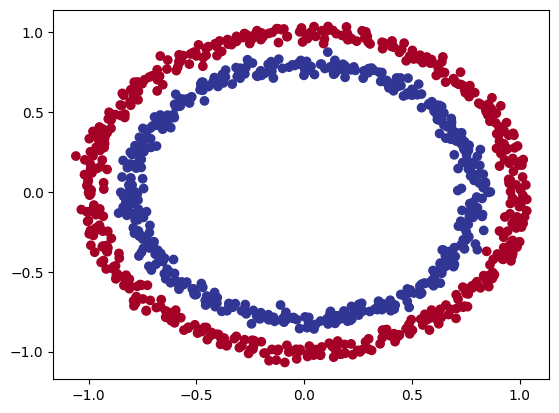

In [34]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [35]:
X_train[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

* Linear - Straight lines
* Non-Linear - Non Straight Lines


In [36]:
# Building a model with non linearity
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # Relu is a non-linear activation function

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [37]:
# Set up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=.15)

In [38]:
# Write a training and evaluation loop for model_3
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  # Training
  model_3.train()

  # 1. Forward Pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits --> pred probs --> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsloss expects raw logits as inputs
                 y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_3.eval() # Put it in evaluation mode
  with torch.inference_mode():
     # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
  # 2 Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 25 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}| Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69285 | Acc: 50.12% | Test Loss: 0.69353| Test Acc: 49.50%
Epoch: 25 | Loss: 0.69197 | Acc: 70.12% | Test Loss: 0.69226| Test Acc: 67.50%
Epoch: 50 | Loss: 0.69152 | Acc: 58.13% | Test Loss: 0.69157| Test Acc: 58.00%
Epoch: 75 | Loss: 0.69111 | Acc: 56.00% | Test Loss: 0.69093| Test Acc: 58.00%
Epoch: 100 | Loss: 0.69068 | Acc: 56.00% | Test Loss: 0.69030| Test Acc: 57.50%
Epoch: 125 | Loss: 0.69021 | Acc: 56.00% | Test Loss: 0.68962| Test Acc: 58.50%
Epoch: 150 | Loss: 0.68970 | Acc: 55.88% | Test Loss: 0.68888| Test Acc: 59.50%
Epoch: 175 | Loss: 0.68915 | Acc: 55.88% | Test Loss: 0.68808| Test Acc: 60.50%
Epoch: 200 | Loss: 0.68852 | Acc: 56.62% | Test Loss: 0.68716| Test Acc: 60.50%
Epoch: 225 | Loss: 0.68777 | Acc: 57.25% | Test Loss: 0.68610| Test Acc: 60.00%
Epoch: 250 | Loss: 0.68690 | Acc: 57.38% | Test Loss: 0.68485| Test Acc: 60.00%
Epoch: 275 | Loss: 0.68592 | Acc: 57.50% | Test Loss: 0.68335| Test Acc: 60.00%
Epoch: 300 | Loss: 0.68483 | Acc: 57.50% | Te

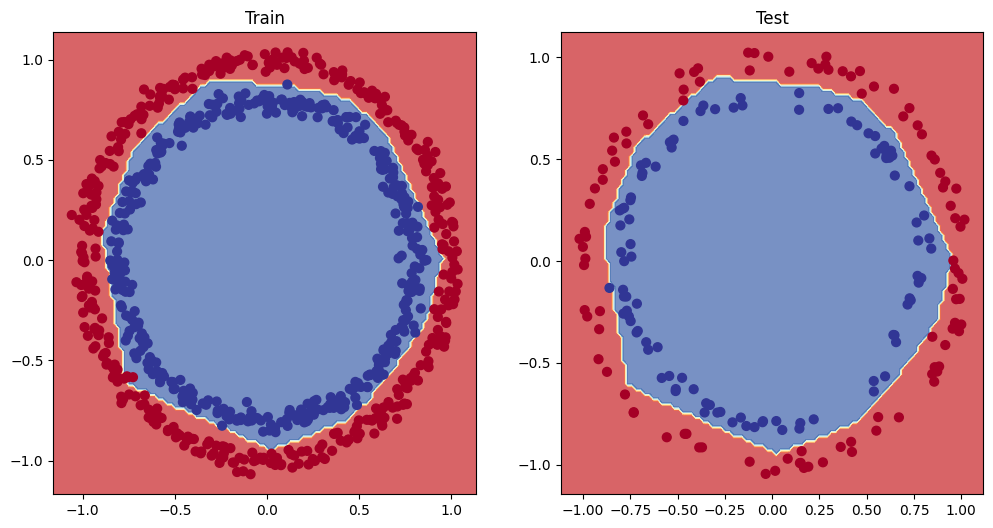

In [39]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

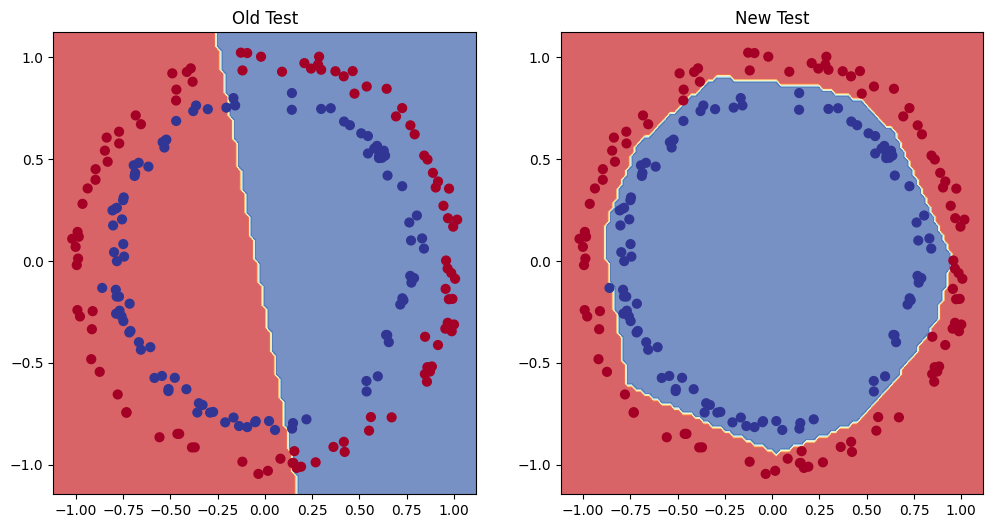

In [40]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Old Test")
plot_decision_boundary(model_1, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("New Test")
plot_decision_boundary(model_3, X_test, y_test)

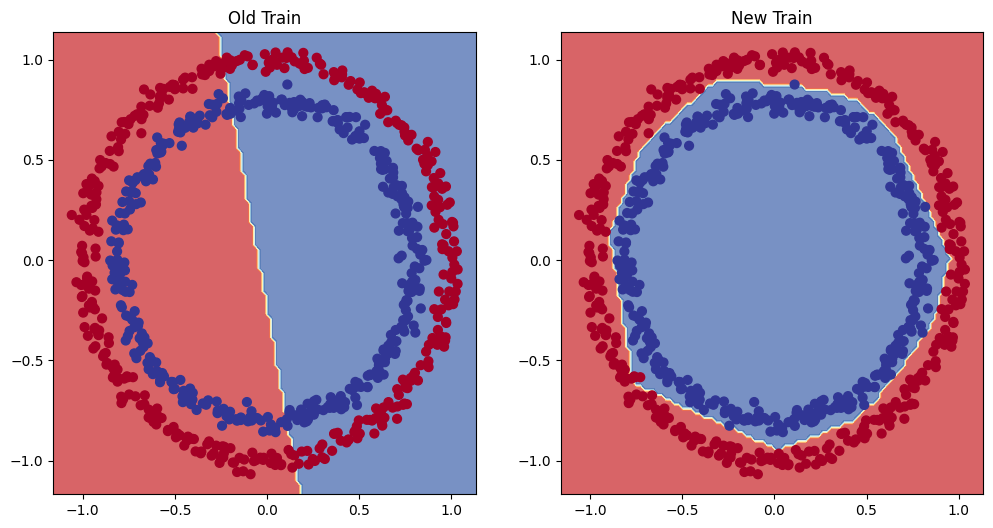

In [41]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Old Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("New Train")
plot_decision_boundary(model_3, X_train, y_train)

## Break down on non-linear activation functions
Nueral networks are given the tools to discover patterns in data and it tries to figure out the pattersns on its own. The tools that the nueral networks use are linear & non-linear functions

## The relu activation function turns all negative numbers to 0.

In [44]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float)
A.dtype

torch.float32

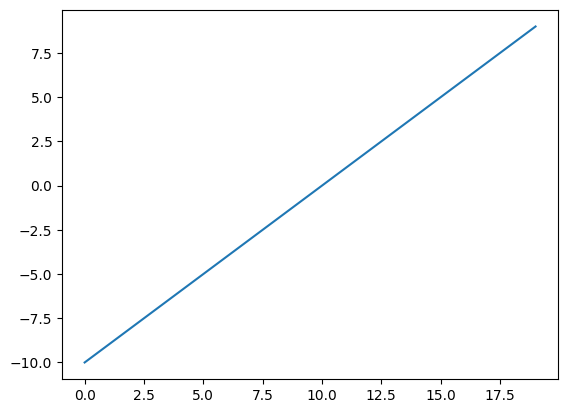

In [45]:
# Look at the tensor
plt.plot(A)

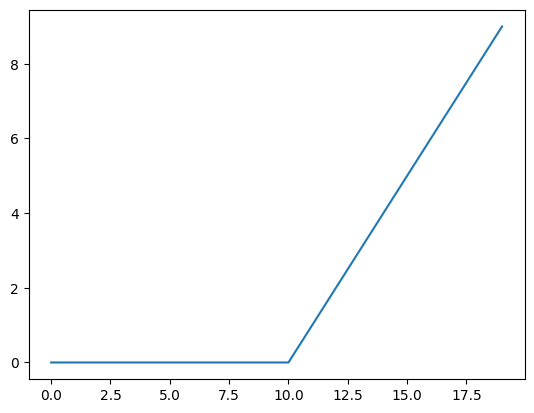

In [47]:
plt.plot(torch.relu(A))

In [49]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # Return the max between 0 and the tensor being passed in: Inputs must be tensor
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

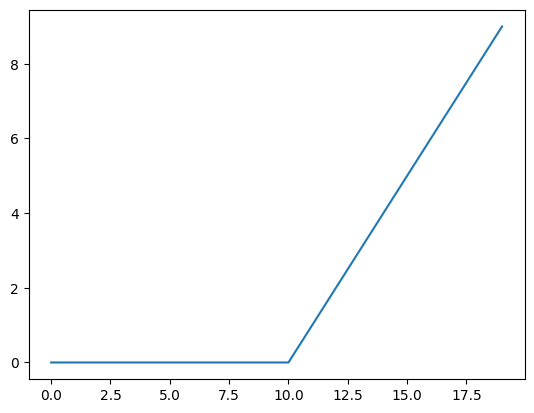

In [50]:
plt.plot(relu(A))

## Doing the same for another non linear function (`Sigmoid`)

In [51]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

In [54]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [52]:
torch.sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

In [53]:
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

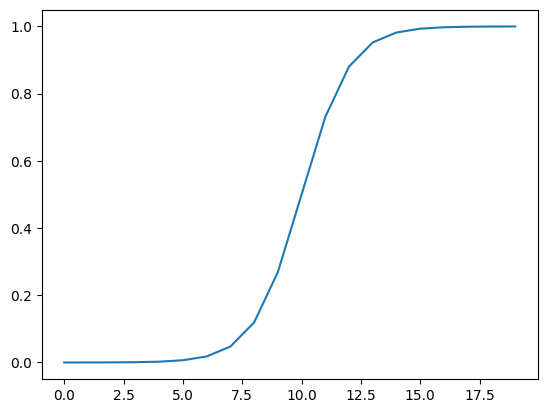

In [55]:
plt.plot(sigmoid(A))

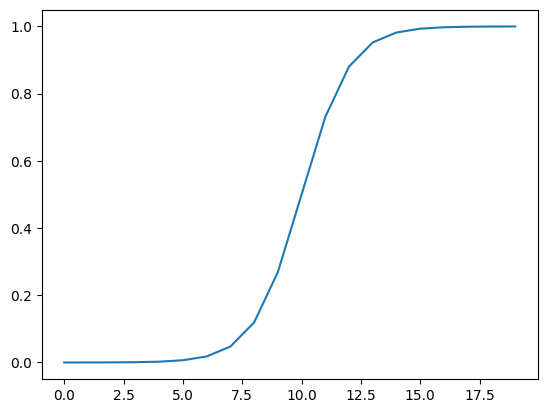

In [56]:
plt.plot(torch.sigmoid(A))